In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
}
sns.set(rc=custom_params, style="ticks", font_scale=1)

In [2]:
df1 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/VH1/map_success.csv")
df2 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/VH2/map_success.csv")
df3 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/VH3/map_success.csv")
df4 = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/VH4/map_success.csv")
df_rep1 = pd.merge(df1, df2, on="Barcode", how="inner", suffixes=('_H', '_L'))
df_rep2 = pd.merge(df3, df4, on="Barcode", how="inner", suffixes=('_H', '_L'))
df_rep1 = df_rep1[df_rep1['Variant_H'] == df_rep1['Variant_L']]
df_rep2 = df_rep2[df_rep2['Variant_L'] == df_rep2['Variant_L']]
df_rep1.drop(columns=['Adjusted Count_H', 'Adjusted Count_L'], inplace=True)
df_rep2.drop(columns=['Adjusted Count_H', 'Adjusted Count_L'], inplace=True)
df_rep1.rename(columns={'VH_H': 'VH', 'VH_L': 'VL', 'Variant_H': 'Variant'}, inplace=True)
df_rep2.rename(columns={'VH_H': 'VH', 'VH_L': 'VL', 'Variant_H': 'Variant'}, inplace=True)
print("Rep 1: ", len(df_rep1))
print("Rep 2: ", len(df_rep2))
df_rep1.to_csv("map_rep1.csv", index=False)
df_rep2.to_csv("map_rep2.csv", index=False)

Rep 1:  3075
Rep 2:  3878


In [3]:
from scipy.stats import f
#check this
def prob_ik(scores=list()):
    scores = [f.cdf(3*(s/min(scores)-1), dfn=3, dfd=1) if min(scores) > 0 and s != min(scores) else 1 if s == min(scores) else 0 for s in scores]
    return scores
print(prob_ik([3,4,5,6]))

[1, 0.3910022189557706, 0.5304777709329569, 0.604181303590592]


In [4]:
#combine top and next bins
for rep in ["rep1", "rep2"]:
    df = pd.read_csv("/projects/brpe7306/fab-library-barcoding/CDRH3_Output/"+rep+"_collapsed.csv")
    df_grouped = df.groupby(['Variant', 'Concentration', 'ref_variant', 'ref_total'])[['Rijk', 'Rjk', 'Nk', 'Njk']].sum().reset_index()
    df_grouped = pd.merge(df_grouped, df.groupby(['Variant', 'Concentration']).agg({'Gj': 'min', 'Hj': 'max'}).reset_index(), on=['Variant', 'Concentration'])
    df_grouped['Bin'] = "top25"
    df_collapsed = df_grouped
    df_collapsed['pij'] = (df_collapsed['Njk']/df_collapsed['Nk'])*(df_collapsed['Rijk']/df_collapsed['Rjk'])/(df_collapsed['ref_variant']/df_collapsed['ref_total'])
    df_collapsed = df_collapsed[df_collapsed['ref_variant'] >= 1000]
    pivot_df = df_collapsed.pivot(index='Variant', columns='Concentration', values='pij')
    merged_df = pd.merge(pivot_df, df_collapsed[['Variant', 'ref_variant']].drop_duplicates(), on='Variant')
    merged_df.columns = [str(col) + 'nM' if str(col).replace('.', '', 1).isdigit() else str(col) for col in merged_df.columns]
    merged_df['Gene'] = merged_df['Variant'].str.split('>').str[0]
    merged_df = merged_df[merged_df['Gene'] != "C118_UCA"]
    merged_df = merged_df.rename(columns={'ref_variant': 'ref_count'})
#     merged_df = merged_df.sort_values('2000.0nM', ascending=False)
    merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')
    merged_df['num_mutations'] = merged_df['Variant'].str.count(';') + 1
    merged_df.loc[merged_df['Variant'].str.contains('WT|:$', regex=True), 'num_mutations'] = 0
    #select based on rep
    if rep == "rep1":
        merged_df = merged_df[['Variant', 'Gene', 'Silent', 'num_mutations', '2.5nM', '50.0nM', '100.0nM', '500.0nM', '1000.0nM', '2000.0nM', 'ref_count']]
        merged_df['Score'] = -np.log(merged_df['50.0nM']/50 + merged_df['100.0nM']/100 + merged_df['500.0nM']/500 + merged_df['1000.0nM']/1000 + merged_df['2000.0nM']/2000)
    elif rep == 'rep2':
        merged_df = merged_df[['Variant', 'Gene', 'Silent', 'num_mutations', '2.5nM', '100.0nM', '500.0nM', '1000.0nM', '2000.0nM', 'ref_count']]
        merged_df['Score'] = -np.log(merged_df['100.0nM']/100 + merged_df['500.0nM']/500 + merged_df['1000.0nM']/1000 + merged_df['2000.0nM']/2000)#Select based on rep
    merged_df = merged_df.sort_values(['Gene', 'num_mutations'])
    merged_df = merged_df.dropna(subset=['Score'])
    merged_df.to_csv("CDRH3_pij_top10bins_"+rep+".csv", index=False, float_format='%.6f')

/tmp/ipykernel_1233576/1324609380.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')
/tmp/ipykernel_1233576/1324609380.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merged_df['Silent'] = merged_df['Variant'].str.contains(r'([A-Z])(\d+)\1')


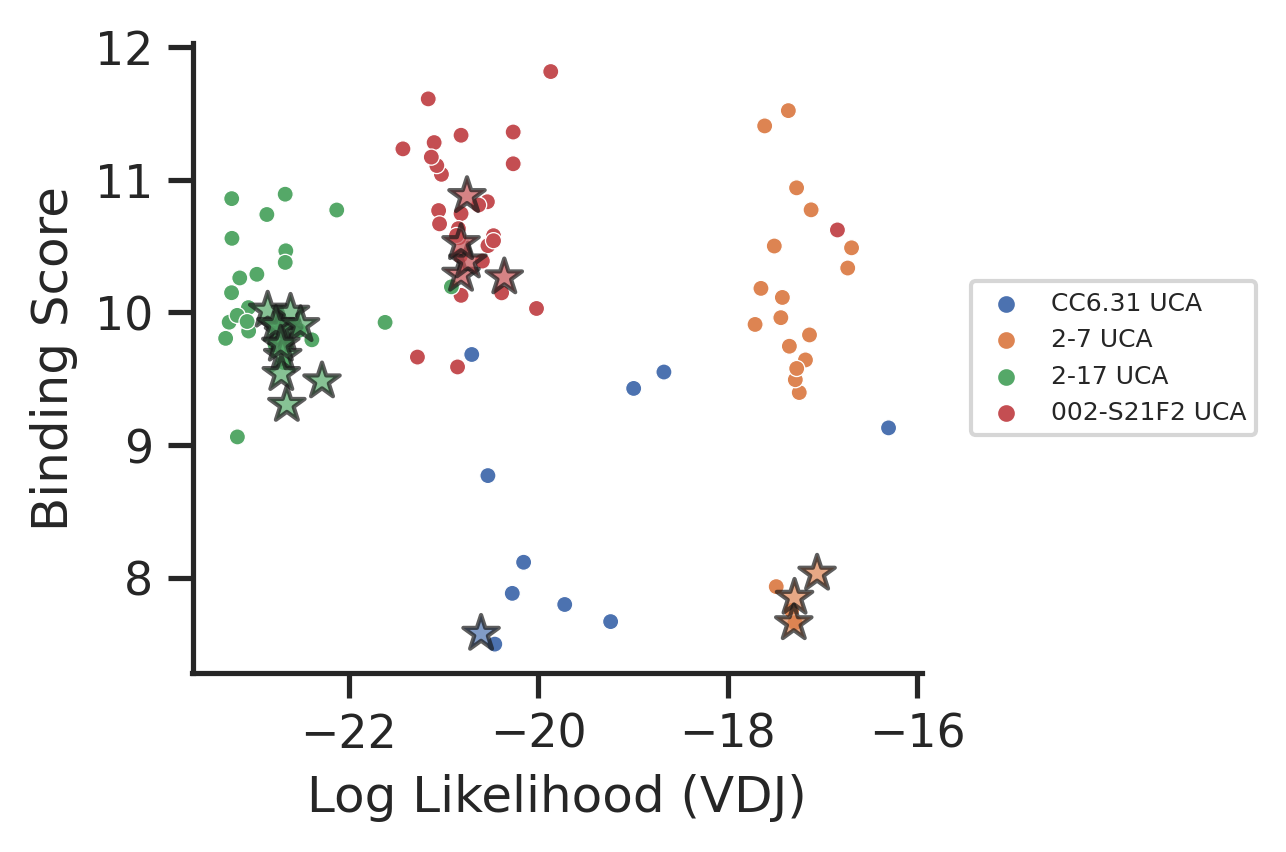

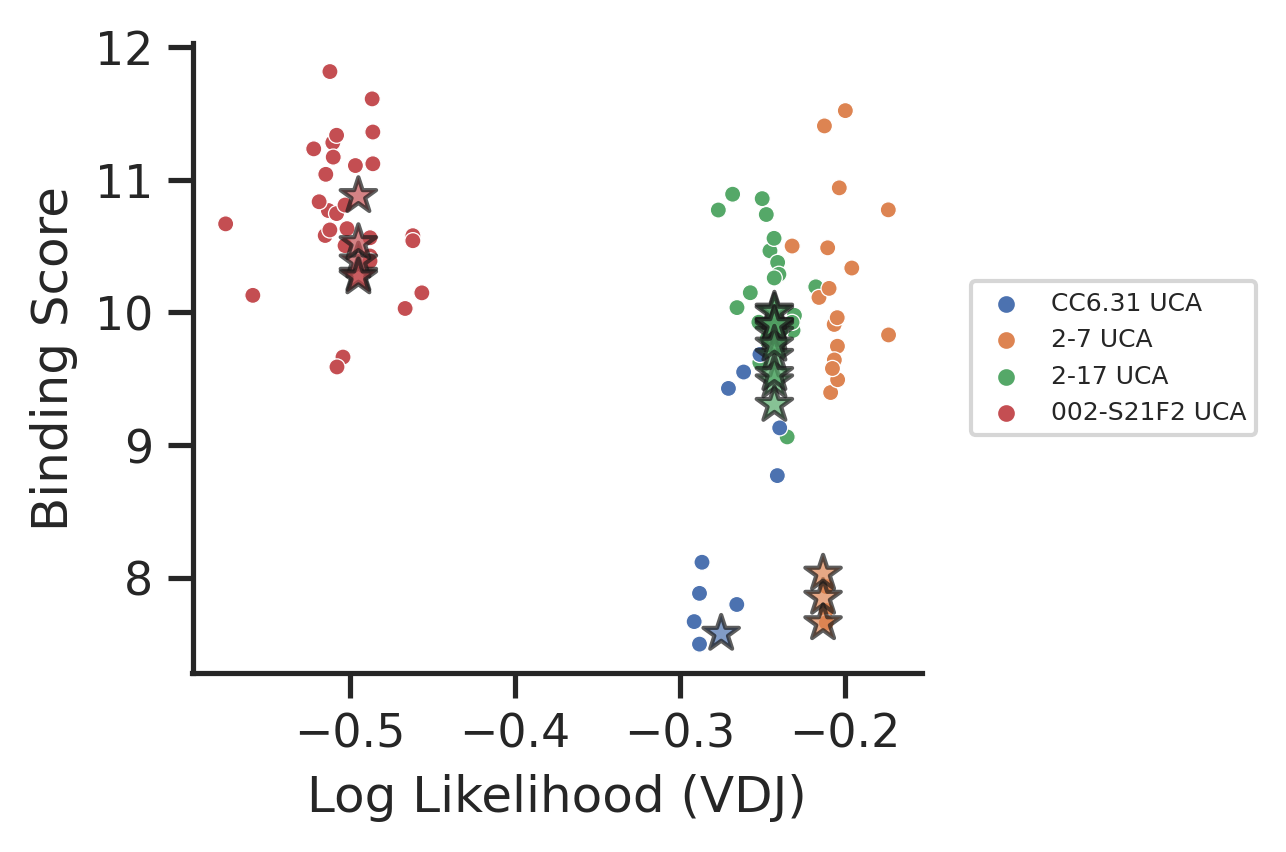

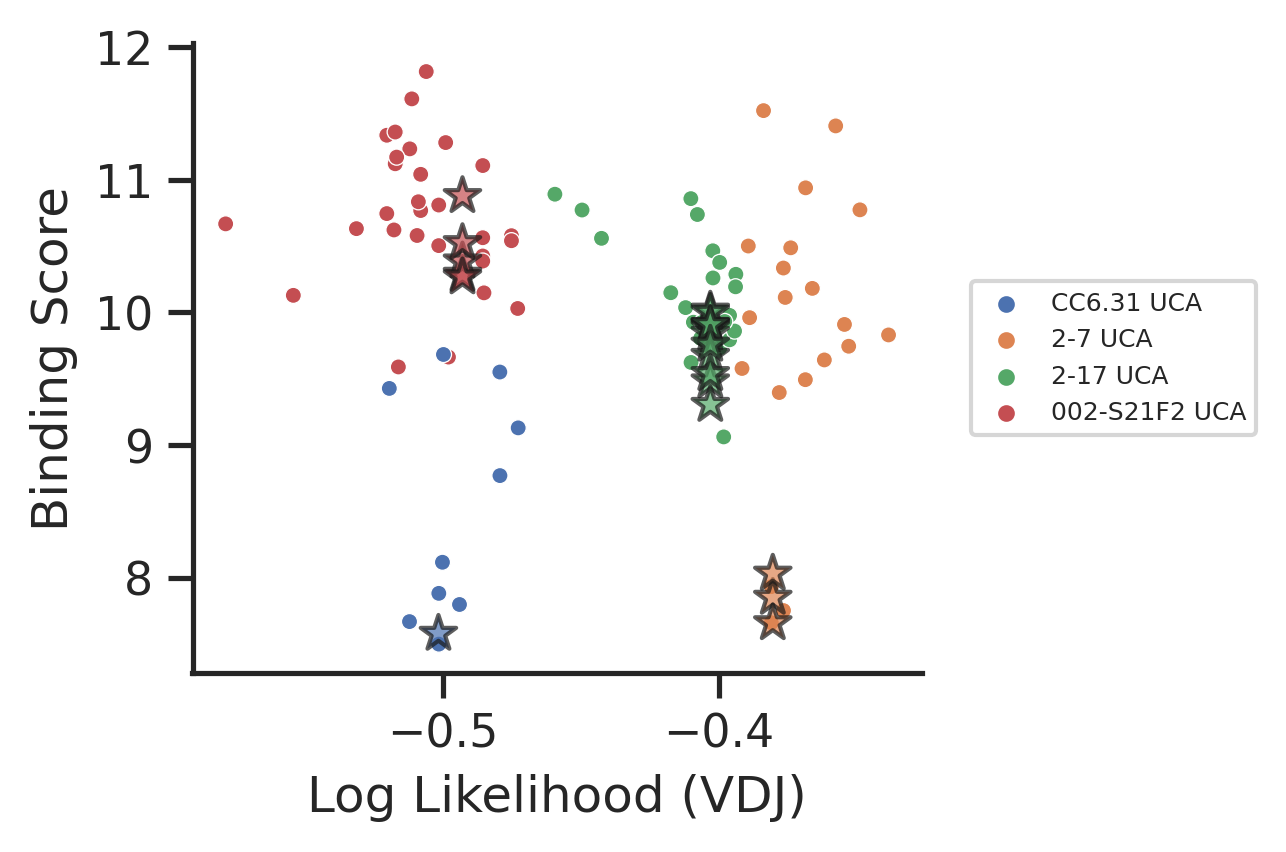

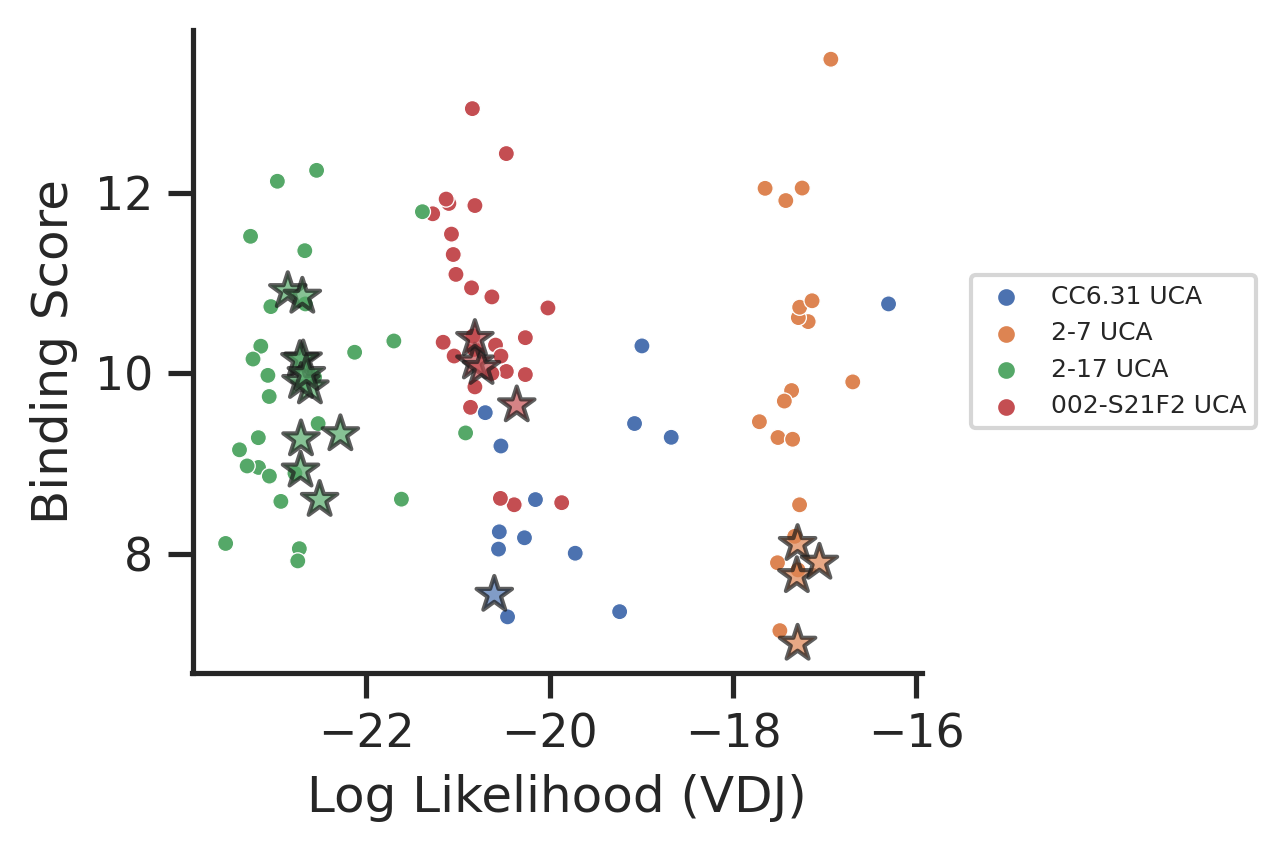

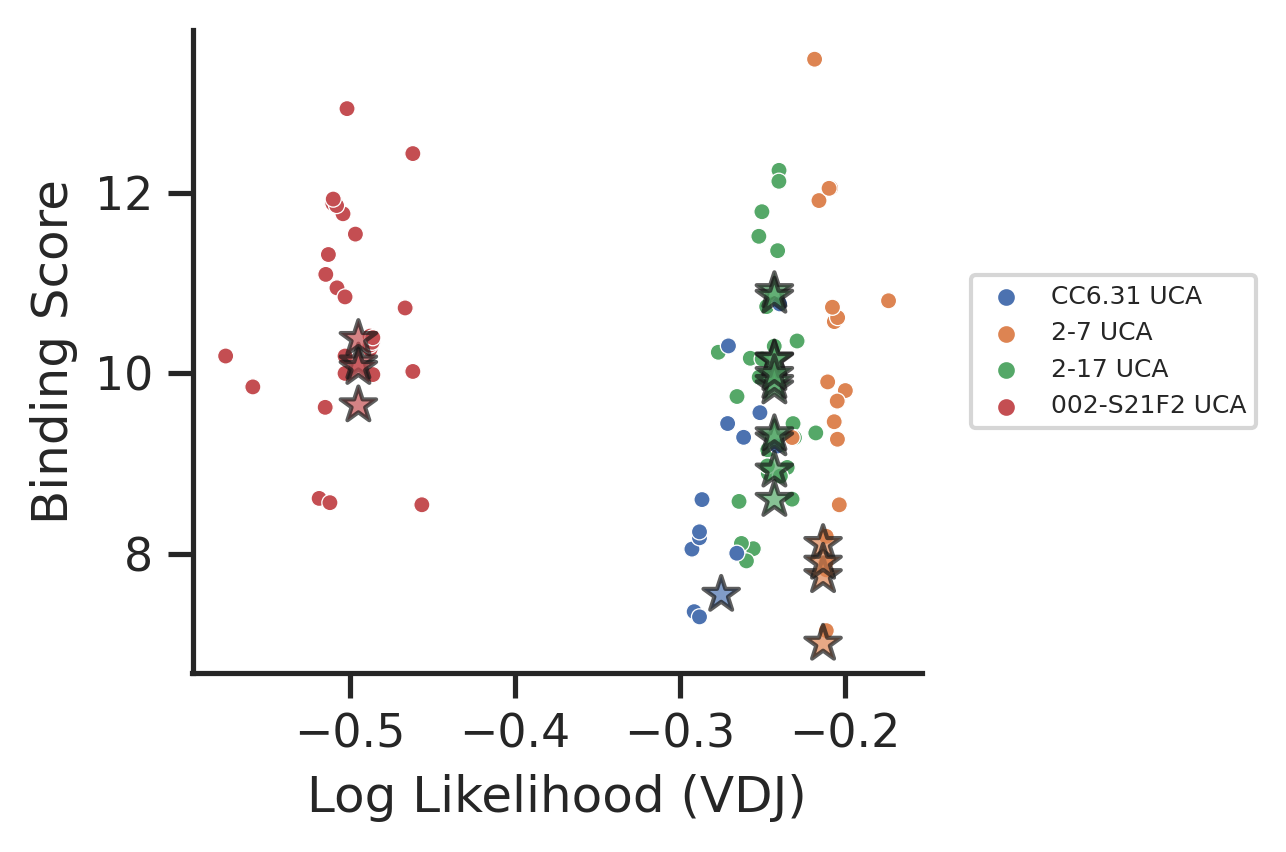

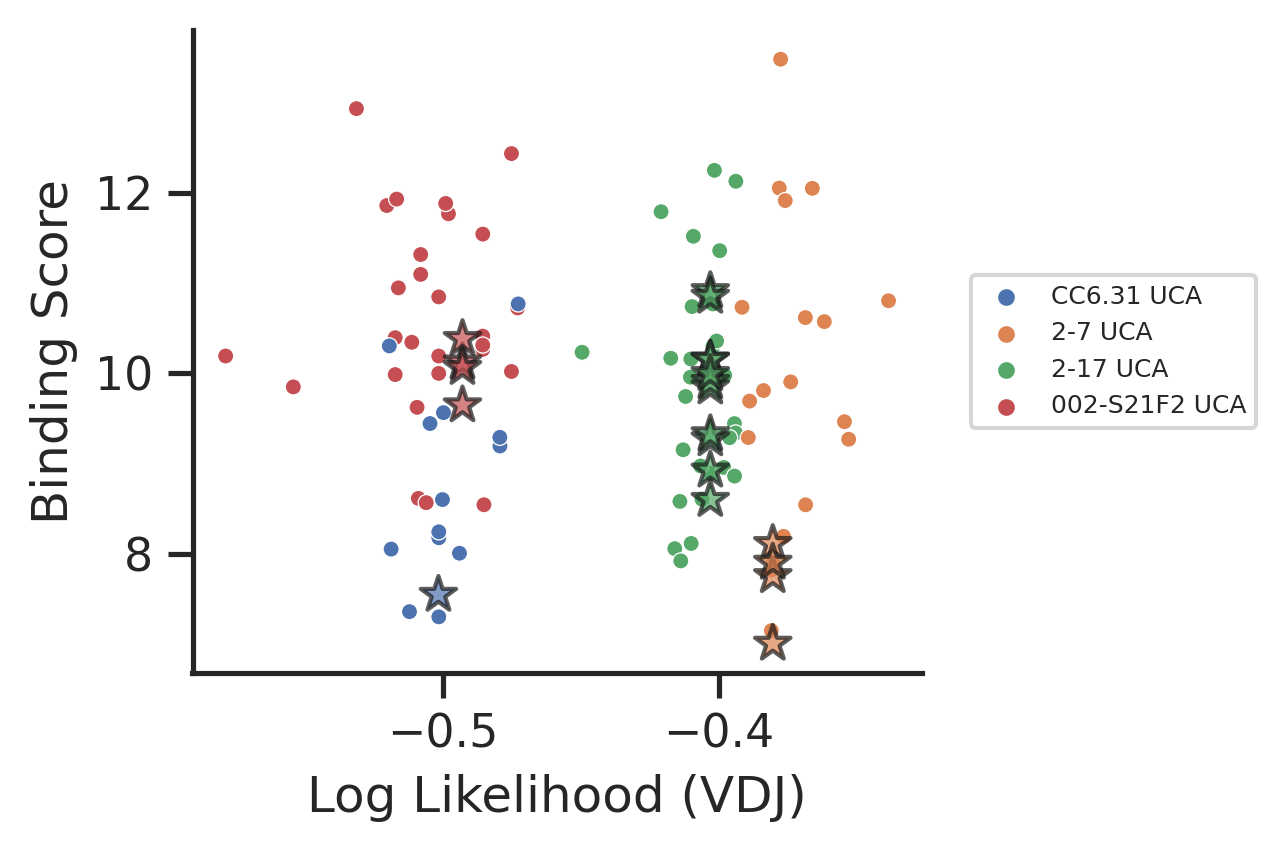

ValueError: I/O operation on closed file

In [3]:
for rep in ["rep1", "rep2"]:
    for prob in ["LL", "pll", "ll_iglm"]:
        probs_df = pd.read_csv("/projects/brpe7306/antiberty/pgen_pll.csv")
        merged_df = pd.read_csv("CDRH3_pij_top10bins_"+rep+".csv")
        df_plot = pd.merge(merged_df, probs_df, on=["Variant"], how="left")
        df_plot = df_plot[df_plot['Gene'] != "C118_UCA"]
        df_plot['Gene'] = df_plot['Gene'].replace({
            'CC631_UCA': 'CC6.31 UCA',
            'Ab_27_UCA': '2-7 UCA',
            'Ab_217_UCA': '2-17 UCA',
            '002S21F2_UCA': '002-S21F2 UCA',
        })
        df_plot['is_WT'] = df_plot.apply(lambda row: row['num_mutations'] == 0 or (row['num_mutations'] == 1 and row['Silent']), axis=1)
        df_output = df_plot
        df_output = df_output.rename(columns={
            'pll': 'll_AntiBERTy',
            'LL': 'll_IGoR'
        })
        df_output = df_output.drop(columns=['Pgen', '2.5nM'])
        df_output.to_csv("source_data_"+rep+".csv", index=False, float_format='%.4f')
        plt.figure(figsize=(4.5,3))
        hue_order = ["CC6.31 UCA", "2-7 UCA", "2-17 UCA", "002-S21F2 UCA"]
        sns.scatterplot(data=df_plot[df_plot['is_WT'] == False], x=prob, y="Score", hue='Gene', s=15, hue_order=hue_order)
        plt.rcParams['legend.markerscale'] = 0.5
        plt.legend(borderaxespad=0.5, prop={'size': 6}, bbox_to_anchor=(1.05, 0.5), loc='center left')
        #plt.legend([],[], frameon=False)
        #plt.scatter(df_plot[df_plot['is_WT'] == True][prob], df_plot[df_plot['is_WT'] == True]['Score'], marker='*', facecolors='none', edgecolors='black', s=80)
        sns.scatterplot(data=df_plot[df_plot['is_WT'] == True], x=prob, y="Score", hue='Gene', marker="*", facecolors='none', ec='k', linewidth=1, s=80, legend=False, hue_order=hue_order, alpha=0.7)
        plt.ylabel("Binding Score")
        plt.xlabel("Log Likelihood (VDJ)")
        plt.tight_layout()
        plt.savefig(prob+"vScore_"+rep+".png")
        plt.show()


df1 = pd.read_csv('/projects/brpe7306/fab-library-barcoding/CDRH3_Output/source_data_rep1.csv')
df2 = pd.read_csv('/projects/brpe7306/fab-library-barcoding/CDRH3_Output/source_data_rep2.csv')
df3 = pd.read_csv('/projects/brpe7306/fab-library-barcoding/CDRH3_Output/rep1_combined.csv')
df4 = pd.read_csv('/projects/brpe7306/fab-library-barcoding/CDRH3_Output/rep2_combined.csv')
with pd.ExcelWriter('source_data.xlsx') as writer:
    df1.to_excel(writer, sheet_name='Score rep1', index=False)
    df2.to_excel(writer, sheet_name='Score rep2', index=False)
    df3.to_excel(writer, sheet_name='Counts rep1', index=False)
    df4.to_excel(writer, sheet_name='Counts rep2', index=False)
writer.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


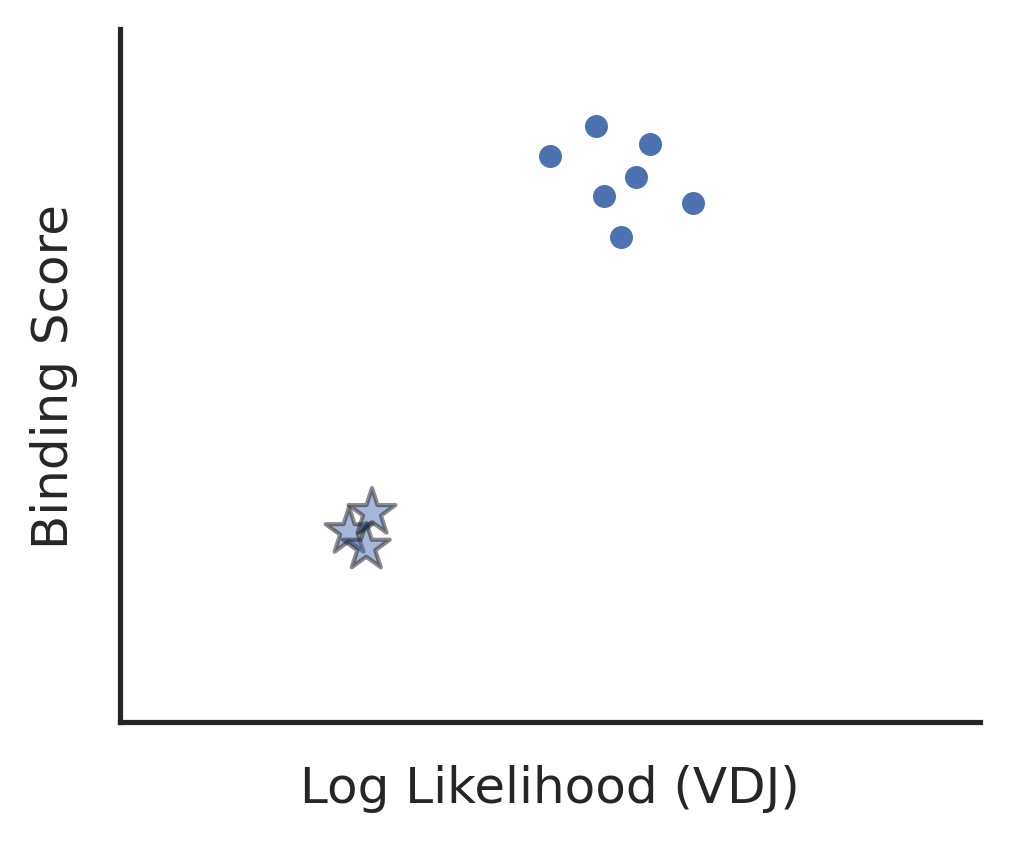

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 1920x1440 with 0 Axes>

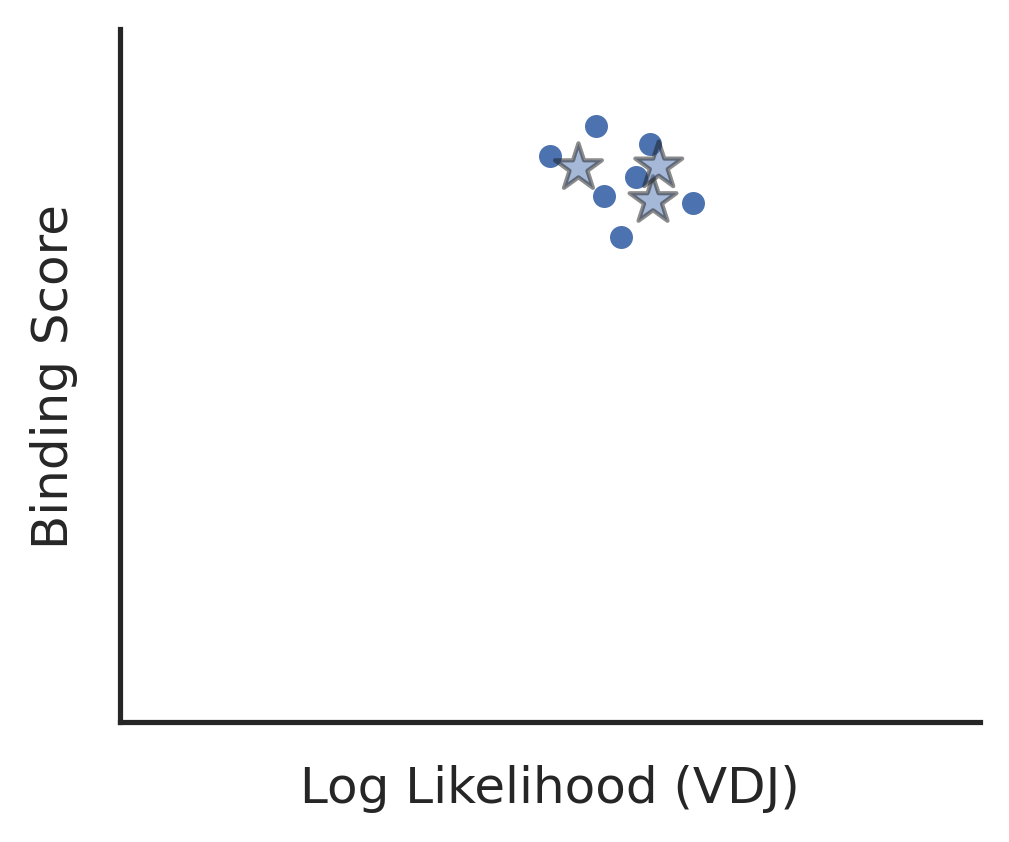

<Figure size 1920x1440 with 0 Axes>

In [47]:
i = 0
for x, y in zip([[0.8, 0.86, 0.88], [1.6, 1.86, 1.88]], [[1.1, 1.01, 1.21], [3.2, 3.01, 3.21]]):  
    plt.figure(figsize=(3.7,3))
    sns.scatterplot(x=[1.8, 1.75, 2, 1.5, 1.85, 1.69, 1.66], y=[3.15, 2.8, 3, 3.27, 3.34, 3.04, 3.44], c=sns.color_palette()[0])
    sns.scatterplot(x=x, y=y, marker="*", ec='k', linewidth=1, s=140, c=[sns.color_palette()[0]]*3, alpha=0.7)
    plt.xlim(0, 3)
    plt.ylim(0, 4)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Binding Score")
    plt.xlabel("Log Likelihood (VDJ)")
    plt.savefig("artificial"+str(i)+".png")
    i += 1
    plt.show()
    plt.clf()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


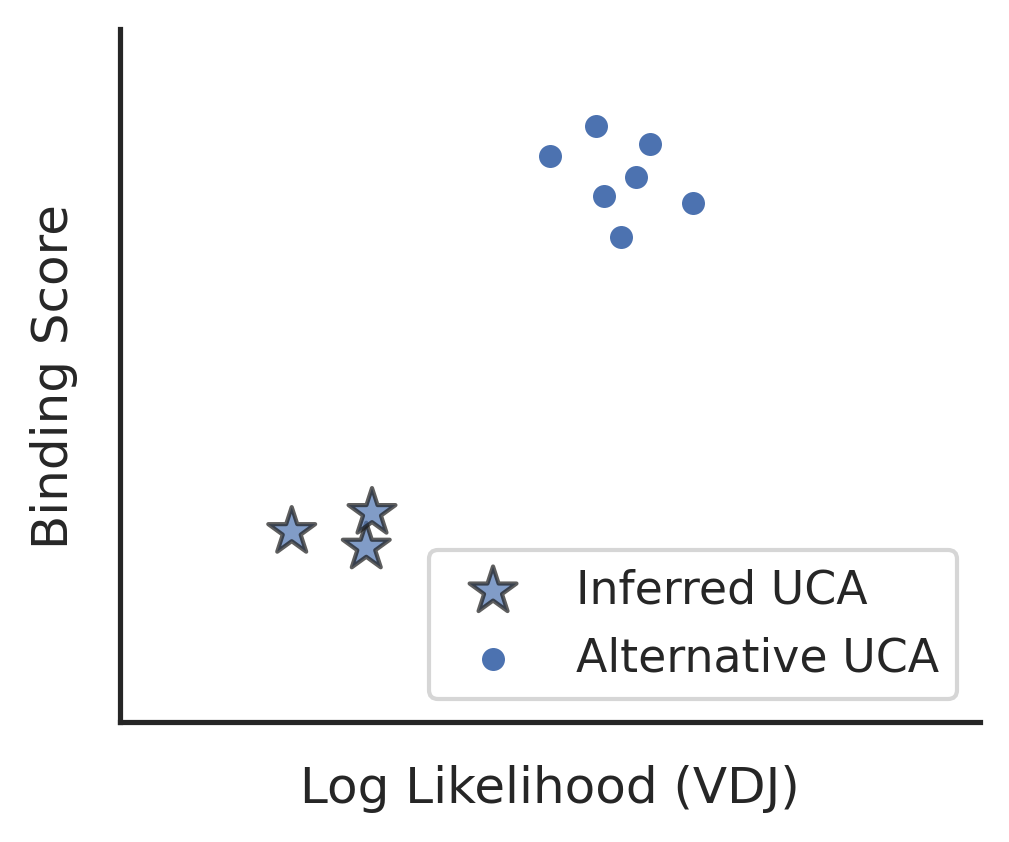

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 1920x1440 with 0 Axes>

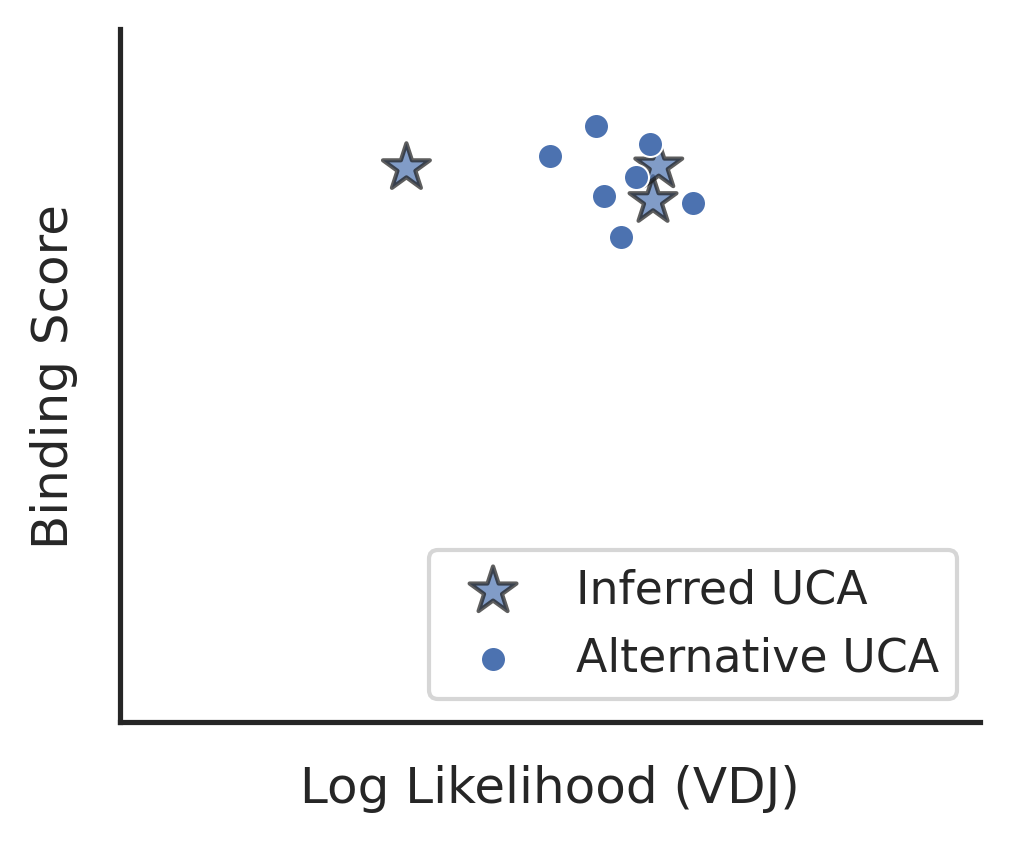

<Figure size 1920x1440 with 0 Axes>

In [10]:
i = 0
for x, y in zip([[0.6, 0.86, 0.88], [1, 1.86, 1.88]], [[1.1, 1.01, 1.21], [3.2, 3.01, 3.21]]):  
    plt.figure(figsize=(3.7,3))
    sns.scatterplot(x=x, y=y, marker="*", ec='k', linewidth=1, s=140, c=[sns.color_palette()[0]]*3, alpha=0.7, label='Inferred UCA')
    sns.scatterplot(x=[1.8, 1.75, 2, 1.5, 1.85, 1.69, 1.66], y=[3.15, 2.8, 3, 3.27, 3.34, 3.04, 3.44], c=sns.color_palette()[0], label='Alternative UCA')
    plt.xlim(0, 3)
    plt.ylim(0, 4)
    plt.legend(loc='lower right')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Binding Score")
    plt.xlabel("Log Likelihood (VDJ)")
    i += 1
    plt.show()
    plt.clf()